# Data Wrangling & Cleaning
  
This notebook deals with the following datasets:  
  
1. 0 - Scraped Games DF.pkl  
Extensive information on over 100,000 games on the Steam store.  
2. review_table.parquet  
table of reviews on the steam store. Each review is a row.  
3. recently_played.pkl  
A set of tuples scraped from the Steam API, listing users' recently played games and playtimes.
  
In this notebook, we will examine and clean each set separately. They will not be combined until closer to the modeling process.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from collections import Counter

from bs4 import BeautifulSoup
from urllib.request import urlopen

import pickle
import pyarrow.parquet as pq

## File 1: Games dataset

In [2]:
with open('../data/raw/0 - Scraped Games DF.pkl', 'rb') as file :
    games_df = pickle.load(file)

games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100894 entries, 0 to 100893
Data columns (total 43 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   app_id                   100894 non-null  int64  
 1   title                    100894 non-null  object 
 2   release_date             100796 non-null  object 
 3   positive_review_percent  35269 non-null   float64
 4   number_of_reviews        35269 non-null   float64
 5   price                    82970 non-null   float64
 6   game_page_link           100894 non-null  object 
 7   tags                     100894 non-null  object 
 8   date_scraped             100894 non-null  object 
 9   developer                100778 non-null  object 
 10  publisher                95915 non-null   object 
 11  description              100894 non-null  object 
 12  interface_languages      100894 non-null  object 
 13  full_audio_languages     100894 non-null  object 
 14  subt

In [3]:
(~games_df['romanian'].isnull()).sum()

2148

In [4]:
# I originally wanted to keep all unused language comment counts, but that makes the df exceed github's max file size.
# Boo-hoo!
# Let's just dump them here. They're the only ones with fewer than 3000 valid values.

cols_to_drop = []

for col in games_df.columns :
    if (~games_df[col].isnull()).sum() < 3000 :
        cols_to_drop.append(col)

games_df = games_df.drop(columns=cols_to_drop)

games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100894 entries, 0 to 100893
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   app_id                   100894 non-null  int64  
 1   title                    100894 non-null  object 
 2   release_date             100796 non-null  object 
 3   positive_review_percent  35269 non-null   float64
 4   number_of_reviews        35269 non-null   float64
 5   price                    82970 non-null   float64
 6   game_page_link           100894 non-null  object 
 7   tags                     100894 non-null  object 
 8   date_scraped             100894 non-null  object 
 9   developer                100778 non-null  object 
 10  publisher                95915 non-null   object 
 11  description              100894 non-null  object 
 12  interface_languages      100894 non-null  object 
 13  full_audio_languages     100894 non-null  object 
 14  subt

### Standardize data types

In [5]:
# The numbers in the comment count columns are strings
# with extra characters. Let's standardize them as ints.

# First, let's get a list of the columns that we need to process.
# That's all columns from the comments df and one column from the
# original game page scraped df.
%store -r top_10_languages
%store -r all_languages
relevant_langs = top_10_languages.copy()
relevant_langs.append('english')
%store relevant_langs

Stored 'relevant_langs' (list)


In [6]:
# Let's make sure the comment counts are ints.

for language in relevant_langs :
    games_df[language] = games_df[language].astype(int, errors='ignore')

In [7]:
# For games that have multiple publishers, developers, etc, they're all stored as one string.
# If we want to use this data eventually, we should split it into lists.
# Some games don't have publishers or developers, and that's fine.
# Oddly, some of them have trailing spaces.
for index, row in games_df.iterrows() :
    if not row['developer'] :
        games_df.at[index, 'developer'] = []
    else :
        if type(row['developer']) != list :
            row['developer'] = row['developer'].split(', ')
            # Since the above line changes the str into a list, we can .strip() each item in the list
            # with a comprehension.
            list_of_developers = [name.strip() for name in row['developer']]
            games_df.at[index, 'developer'] = list_of_developers

    # And again.
    if not row['publisher'] :
        games_df.at[index, 'publisher'] = []
    else :
        if type(row['publisher']) != list :
            row['publisher'] = row['publisher'].split(', ')
            list_of_publishers = [name.strip() for name in row['publisher']]
            games_df.at[index, 'publisher'] = list_of_publishers

In [8]:
# The tags are also just a string. We need them listed.
tags_list = []

for index, row in games_df.iterrows() :
    if (type(row['tags']) != list) & (row['tags'] != '') :
        tags_list = row['tags'].strip('[]').split(',')
        games_df.at[index, 'tags'] = tags_list

print(type(games_df.loc[0, 'tags']))

<class 'list'>


In [9]:
# Same problem for our languages types columns (interface, audio, subitles).

for index, row in games_df.iterrows() :
    if (type(row['interface_languages']) != list) & (row['interface_languages'] != '') :
        languages_list = row['interface_languages'].strip('[]').split(', ')
        games_df.at[index, 'interface_languages'] = languages_list
    if (type(row['full_audio_languages']) != list) & (row['full_audio_languages'] != '') :
        languages_list = row['full_audio_languages'].strip('[]').split(', ')
        games_df.at[index, 'full_audio_languages'] = languages_list
    if (type(row['subtitles_languages']) != list) & (row['subtitles_languages'] != '') :
        languages_list = row['subtitles_languages'].strip('[]').split(', ')
        games_df.at[index, 'subtitles_languages'] = languages_list

# Check.
print(type(games_df.loc[0, 'interface_languages']))

<class 'list'>


In [10]:
# For future reference, let's create a dictionary of tags codes & their meanings.
# We can get that from the search page.
# Keys will be the codes. Values will be the names.
url = 'https://store.steampowered.com/search'
html = urlopen(url)
soup = BeautifulSoup(html, 'lxml')

# The relevant data is in this one code block.
code_block = soup.find('div', id="TagFilter_Container")

# Create the empty dict.
tags_dict = {}

# Iterate over all 400+ tags described in the code block.
for listing in code_block.find_all('div', class_='tab_filter_control_row') :
    tag_code = listing.get('data-value')
    tag_name = listing.get('data-loc')
    tags_dict[tag_code] = tag_name

# We'll probably need it later, so let's save it a couple ways.
# Weirdly, it's quicker and easier to do this via a DF.
tags_dict_df = pd.DataFrame.from_dict(tags_dict, orient='index')
tags_dict_df.to_csv('../data/raw/tag_dictionary.csv')
%store tags_dict

Stored 'tags_dict' (dict)


In [11]:
# For standardization, let's convert the numeric tags to text tags now.
# Our scraper went through various iterations, so some of them are already
# text tags.

for index, row in games_df.iterrows() :
    if row['tags'] != ['Failed'] :
        if type(row['tags'][0]) != str :
            tag_container = []
            for tag in row['tags'] :
                tag_container.append(tags_dict[tag])
            games_df.at[index, 'tags'] = tag_container.copy()

### Sanity checks

<Axes: >

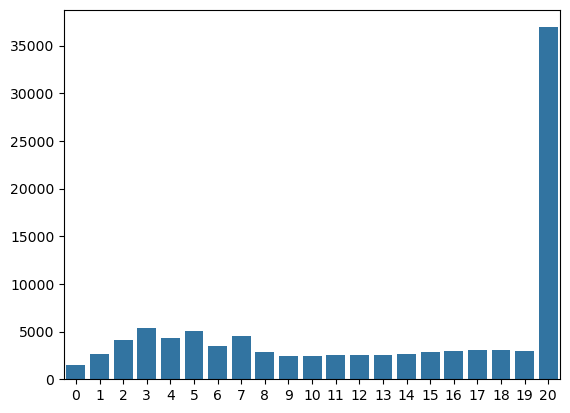

In [12]:
# Since our tag_list column is very important to us, let's make sure
# that the entries are reasonably comparable.

# In order to count the number of tags in each game's tag list,
# let's turn that column into a list of lists (by way of a series)
# so that we can use a list comprehension to get a list of len()s.
series_of_tags_column_values = games_df['tag_list']
list_of_tags_column_values = series_of_tags_column_values.tolist()
tags_values_lengths = [len(x) for x in list_of_tags_column_values]

# Now we organize the counts into a dictionary, where the keys are
# the lengths and the values are the frequencies of those lengths.
dict_of_lenghts = {}

for length in tags_values_lengths :
    if length in dict_of_lenghts :
        dict_of_lenghts[length] += 1
    else :
        dict_of_lenghts[length] = 1

# Now let's plot it.
lengths = []
for key, value in dict_of_lenghts.items() :
    lengths.append((key, value))

x_axis = [x[0] for x in lengths]
y_axis = [x[1] for x in lengths]

sns.barplot(x=x_axis, y=y_axis)

# Looks not too bad. Looks like the vast majority of games have 20 tags.

In [13]:
# I discovered that summing the number of comments in the top 10 loc languages + En
# as recorded in our DF resulted in a HIGHER comment count than Steam displays (which
# is the one we grabbed from Steam as "number_of_reviews").

# Thus the "number_of_reviews" column may be useless to us, but I'm loathe to let go
# of any data. Let's keep it for now, and just add a new column that we'll use for our
# calculations: "relevant_langs_review_sum", which we calculate as the sum of the
# existing reviews.

games_df['relevant_langs_comments_sum'] = None

for index, row in games_df.iterrows() :
    games_df.loc[index, 'relevant_langs_comments_sum'] = row[relevant_langs].sum()

games_df['relevant_langs_comments_sum'] = games_df['relevant_langs_comments_sum'].astype(int)

### Determine completeness

In [14]:
# Our main feature is the tags, so we should make sure that all rows have them.
# We can use the 'tags' col for this, since a presence in the 'tags' column
# implies presence in the 'tag_list' column as well.
indexes_to_drop = []

for index, row in games_df.iterrows() :
    if len(row['tags']) == 0 :
        indexes_to_drop.append(index)

print(len(indexes_to_drop))
# Excellent! Looks like we're in the clear there.

0


### Further standardization

In [15]:
# I've noticed that the way languages are written in the langauge types columns is different
# from the way they're written in the languages columns. We'll need them to match up if we
# want to do a comparative analysis.

# The problems are threefold.
# First, the capitalization is different.
# Second, the language types columns split up some languages (for example, Spanish is split
#   into "Spanish - Spain" and "Spanish - Latin America").
# Third, some are just spelled differently, like "schinese" and "Simplified Chinese".

# Since I don't want to lose data, I'll make new columns to hold the 'reduced' versions
# (for example, where 'Spanish- Spain' is 'reduced' to 'spanish')

# First, make cols and fill 'em with lists
games_df['mod_interface_languages'] = [[] for _ in range(len(games_df))]
games_df['mod_full_audio_languages'] = [[] for _ in range(len(games_df))]
games_df['mod_subtitles_languages'] = [[] for _ in range(len(games_df))]


# Next, let's just lowcap everything. Turn down the volume a bit.
for index, row in games_df.iterrows() :

    for item in row['interface_languages'] :
        # Make a easy-to-mess-with version
        lang = item.lower()

        # Check to see if it's a variant, replace if so
        for language in relevant_langs :
            if language in lang :
                lang = language

        # And it looks like there are three special cases we need to handle specifically.
        if lang == 'simplified chinese' :
            lang = 'schinese'
        
        if lang == 'portuguese - brazil' :
            lang = 'brazilian'
        
        if lang == 'korean' :
            lang = 'koreana'

        # Add the lowercaseified, standardizified version to the col in the main df
        games_df.loc[index, 'mod_interface_languages'].append(lang)


    # Now we do the same for the other two langauge type columns...
    for item in row['full_audio_languages'] :
        # Make a easy-to-mess-with version
        lang = item.lower()

        # Check to see if it's a variant, replace if so
        for language in relevant_langs :
            if language in lang :
                lang = language

        # And it looks like there are two special cases we need to handle specifically.
        if lang == 'simplified chinese' :
            lang = 'schinese'
        
        if lang == 'portuguese - brazil' :
            lang = 'brazilian'

        if lang == 'korean' :
            lang = 'koreana'

        # Add the lowercaseified, standardizified version to the col in the main df
        games_df.loc[index, 'mod_full_audio_languages'].append(lang)


    for item in row['subtitles_languages'] :
        # Make a easy-to-mess-with version
        lang = item.lower()

        # Check to see if it's a variant, replace if so
        for language in relevant_langs :
            if language in lang :
                lang = language

        # And it looks like there are two special cases we need to handle specifically.
        if lang == 'simplified chinese' :
            lang = 'schinese'
        
        if lang == 'portuguese - brazil' :
            lang = 'brazilian'

        if lang == 'korean' :
            lang = 'koreana'

        # Add the lowercaseified, standardizified version to the col in the main df
        games_df.loc[index, 'mod_subtitles_languages'].append(lang)

### Designing some useful columns

In [16]:
# Let's look at how our prices are distributed...
list_of_prices = games_df['price']
counts = list_of_prices.value_counts()
print(counts[counts > 50])
print(counts[counts > 50].sum())

0.0        17725
499.0       8652
99.0        7784
299.0       7206
999.0       7169
199.0       6072
1999.0      3507
399.0       3499
1499.0      3388
599.0       2649
699.0       2371
799.0       2270
2499.0      1279
2999.0      1200
899.0       1034
1199.0      1018
1299.0       925
3999.0       568
1099.0       509
1399.0       404
1799.0       362
1599.0       292
5999.0       245
4999.0       234
1699.0       232
3499.0       218
1899.0       158
4499.0        91
349.0         76
149.0         72
2299.0        65
19999.0       52
Name: price, dtype: int64
81326


In [17]:
# We can see that almost 5/6 of our games fall into just a
# few price points! That's significant to know. Let's use
# these as bins, then "below that" and "above that" as
# separate bins, for a total of 13 bins.

# I'm not 100% confident in the efficacy of this method,
# so let's preserve the original price data in the DF.
# Later, when modeling, we can see if there's a reason
# to use one or the other.

ranges = [-5, 0, 700, 1200, 1700, 2200, 2700, 3200, 3700, 4200, 4700, 5200, 5700, 6500, 7500, np.inf]
range_names = ['none', 'under 10', '999', '1499', '1999', '2499', '2999', '3499', '3999', '4499', '4999', '5499', '5999', '6999', 'over 80']
games_df['price_category'] = pd.cut(games_df['price'], bins=ranges, labels=range_names)

In [18]:
# Since we won't necessarily be dealing with comment counts
# in individual lanugages, let's compact them into a single
# column for tidy safekeeping.

games_df['language_comment_counts'] = ''

for index, row in games_df.iterrows() :
    holding_dict = {}
    for language in relevant_langs :
        holding_dict[language] = row[language]
    games_df.at[index, 'language_comment_counts'] = holding_dict.copy()

### Save and quit

In the next notebook, we will pare down the columns and perform other steps to prepare for modeling.

We'll also save some of the variables we need along the way.

In [19]:
# First, let's reorder or coulmns to a more sane order.
new_column_order = ['app_id', 'title', 'developer', 'publisher', 'description', 'release_date', 'price', \
                    'price_category', 'number_of_reviews', 'positive_review_percent', 'relevant_langs_comments_sum', \
                    'tags', 'tag_list', 'interface_languages', 'mod_interface_languages', 'full_audio_languages', \
                    'mod_full_audio_languages', 'subtitles_languages', 'mod_subtitles_languages', \
                    'language_comment_counts', 'game_page_link', 'date_scraped']

# Do it
games_df = games_df.reindex(columns=new_column_order)

# We'll also drop some data that I wish we could keep into the preprocessing stage, just because GitHub
# doesn't like my file sizes.
columns_to_drop = ['title', 'game_page_link', 'developer', 'publisher', \
                   'description', "number_of_reviews", "interface_languages", "full_audio_languages", \
                    "subtitles_languages"]

games_df = games_df.drop(columns=columns_to_drop)

# Check it
games_df.columns

Index(['app_id', 'release_date', 'price', 'price_category',
       'positive_review_percent', 'relevant_langs_comments_sum', 'tags',
       'tag_list', 'mod_interface_languages', 'mod_full_audio_languages',
       'mod_subtitles_languages', 'language_comment_counts', 'date_scraped'],
      dtype='object')

In [20]:
with open('../data/interim/1 - Games DF - Wrangled', 'wb') as file :
    pickle.dump(games_df, file)

%store all_languages

Stored 'all_languages' (list)


## File 2: Review Table

Since this dataset has relatively few columns, there's not much to explore.  
  
However, I did identify the following avenues for improvement:  
  
1. We've only scraped a maximum of 10 reviews per user. Re-visiting those users' pages and looking for more reivews might make for a quick increase in our overall review count, since these are our proven high-review-count users.

2. There's a slight issue with our "helpful" counts: when there is no helpful count but there IS a "funny" count (funny counts went unnoticed in my scraper design), the funny count is recorded as the helpful count. Fortunately this doesn't seem to have happened too much, and the funny count may also be a reasonable indicator of the utility of the review.

In [21]:
review_table = pq.read_table('../data/raw/review_table.parquet')
review_df = review_table.to_pandas()
review_table = None
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316127 entries, 0 to 316126
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user             316127 non-null  object 
 1   app_id           316127 non-null  int64  
 2   positive         316127 non-null  int64  
 3   total_playtime   316127 non-null  float64
 4   review_playtime  316127 non-null  float64
 5   text             316127 non-null  object 
 6   helpful_count    316127 non-null  int64  
 7   review_date      316127 non-null  object 
 8   edit_date        316127 non-null  object 
 9   date_scraped     316127 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 24.1+ MB


In [22]:
for col in review_df.columns :
    print(f'-----{col}-----')
    print(review_df[col].describe())
    print('')

-----user-----
count                316127
unique                84610
top       76561198351839822
freq                     10
Name: user, dtype: object

-----app_id-----
count    3.161270e+05
mean     6.470574e+05
std      5.872987e+05
min      1.000000e+01
25%      2.346500e+05
50%      4.312400e+05
75%      1.063730e+06
max      2.900190e+06
Name: app_id, dtype: float64

-----positive-----
count    316127.000000
mean          0.847884
std           0.359134
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: positive, dtype: float64

-----total_playtime-----
count    316127.000000
mean        437.053191
std        1373.546306
min           0.000000
25%           9.600000
50%          43.400000
75%         214.600000
max       71930.600000
Name: total_playtime, dtype: float64

-----review_playtime-----
count    316127.000000
mean        208.025883
std         747.330349
min           0.000000
25%           4.800000


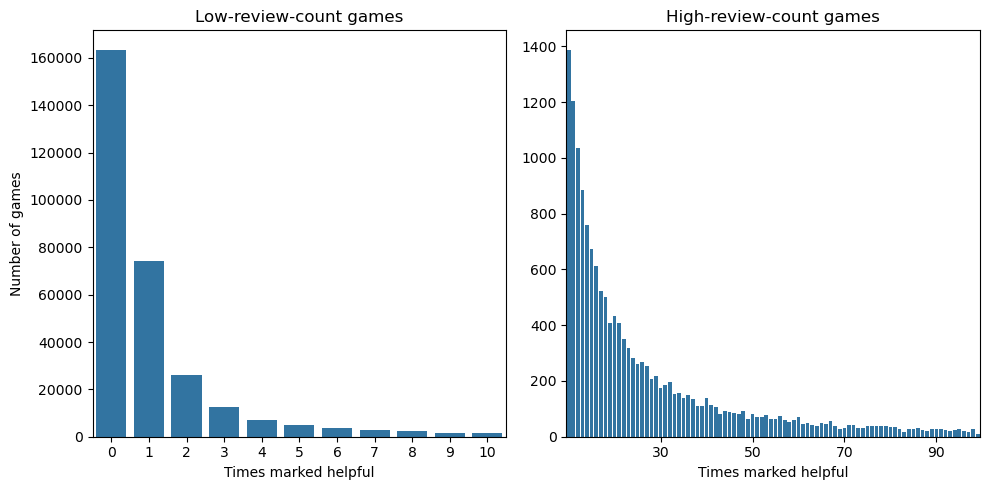

In [23]:
helpful_counts = review_df['helpful_count'].value_counts()
helpful_counts.sort_index(inplace=True)
low_review = helpful_counts[:11]
high_review = helpful_counts[10:100]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x=low_review.index, y=low_review.values, ax=ax[0])
ax[0].set_title('Low-review-count games')
ax[0].set_xlabel('Times marked helpful')
ax[0].set_ylabel('Number of games')
sns.barplot(x=high_review.index, y=high_review.values, ax=ax[1])
ax[1].set_title('High-review-count games')
ax[1].set_xlabel('Times marked helpful')
ax[1].set_xticks([20, 40, 60, 80])

plt.tight_layout()
plt.show()

In [24]:
unplayed_reviews = review_df[review_df['review_playtime']<0.0001]

print(f"{len(unplayed_reviews)} games were reviewed without being played.")

5034 games were reviewed without being played.


In [25]:
played_reviews = review_df[review_df['review_playtime']>0.0001]

pos_unplayed_review_percent = unplayed_reviews['positive'].sum()/len(unplayed_reviews)
pos_played_review_percent = played_reviews['positive'].sum()/len(played_reviews)

print(f'Positive review percent of played games: {pos_played_review_percent:.2f}')
print(f'Positive review percent of unplayed games: {pos_unplayed_review_percent:.2f}')

Positive review percent of played games: 0.85
Positive review percent of unplayed games: 0.72


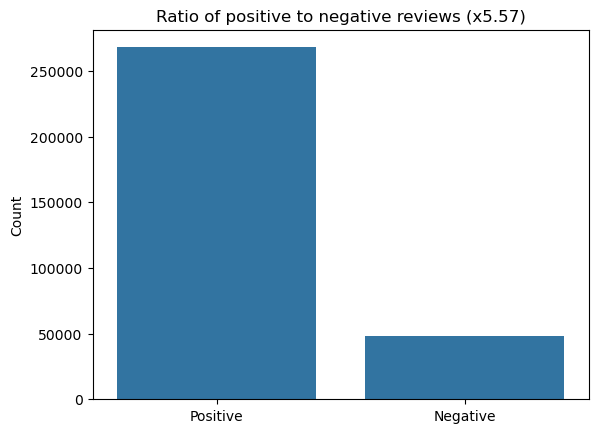

In [26]:
positives = review_df['positive'].sum()
negatives = len(review_df) - positives
ratio = positives/negatives
sns.barplot(x=['Positive', 'Negative'], y=[positives, negatives])
plt.title(f'Ratio of positive to negative reviews (x{round(ratio, 2)})')
plt.ylabel('Count')
plt.show()

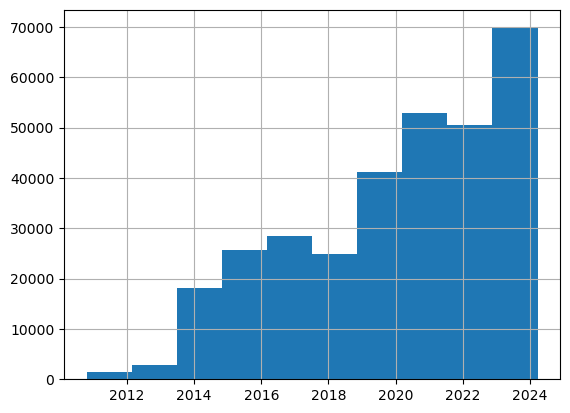

In [27]:
review_df['review_date'].hist()
plt.show()

In [28]:
late_edits = review_df[review_df['review_date'] != review_df['edit_date']]
review_lags = late_edits['edit_date'] - late_edits['review_date']
review_lags.describe()

count                          30007
mean     533 days 18:53:23.972406440
std      705 days 11:49:18.456795352
min                  1 days 00:00:00
25%                 25 days 00:00:00
50%                250 days 00:00:00
75%                750 days 00:00:00
max               4756 days 00:00:00
dtype: object

In [29]:
review_texts = review_df['text']
review_texts.describe()

count     316127
unique    281056
top         good
freq        1262
Name: text, dtype: object

Text(0, 0.5, 'Number of users with that many reviews')

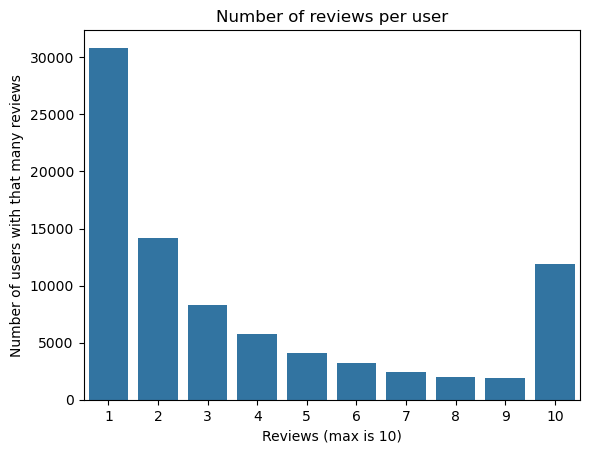

In [30]:
review_counts = review_df['user'].value_counts()
grouped_counts = review_counts.groupby(review_counts).agg('count')

sns.barplot(x=grouped_counts.index, y=grouped_counts.values)
plt.title('Number of reviews per user')
plt.xlabel('Reviews (max is 10)')
plt.ylabel('Number of users with that many reviews')

## File 3: Recently Played

The above data was scraped from the webpage. The following data was collected from the API. That's the reason for the different size of the dataset, as well as the overlapping data (specifically, a player's lifetime playtime for a game).

Ideally, we could combine these datasets into one table, as it would have no repeated information, though there would be quite a few nulls where one dataset was smaller than the other. However, this task may not be within the scope of the current modeling project.

The data for recently played games is stored in a tuple with the following schema:  
  
  -- user id (str)  
  -- app id (int)  
  -- time played in last 2 weeks (int, minutes)  
  -- time played in forever (int, minutes)


In [31]:
with open('../data/raw/recently_played.pkl', 'rb+') as file:
    recently_played_tuples = pickle.load(file)

recently_played_df = pd.DataFrame(recently_played_tuples, columns=['user', 'app_id', 'playtime_2w', 'playtime_f'])
recently_played_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683058 entries, 0 to 1683057
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user         1683058 non-null  object
 1   app_id       1683058 non-null  int64 
 2   playtime_2w  1683058 non-null  int64 
 3   playtime_f   1683058 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 51.4+ MB


In [32]:
recently_played_df.describe()

,app_id,playtime_2w,playtime_f
count,1.683058e+06,1.683058e+06,1.683058e+06
mean,8.871855e+05,5.800291e+02,3.516038e+04
std,7.538794e+05,1.510151e+03,1.237312e+05
min,7.000000e+00,1.000000e+00,0.000000e+00
25%,2.841600e+05,2.900000e+01,3.510000e+02
50%,5.946500e+05,1.260000e+02,2.437000e+03
75%,1.328670e+06,5.100000e+02,1.582300e+04
max,2.902410e+06,2.015900e+04,5.574135e+06


C:\Users\Josh\AppData\Local\Temp\ipykernel_15368\3816339695.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupby_apps = recently_played_df.groupby('app_id').agg('mean') \


array([[<Axes: title={'center': 'playtime_2w'}>,
        <Axes: title={'center': 'playtime_f'}>]], dtype=object)

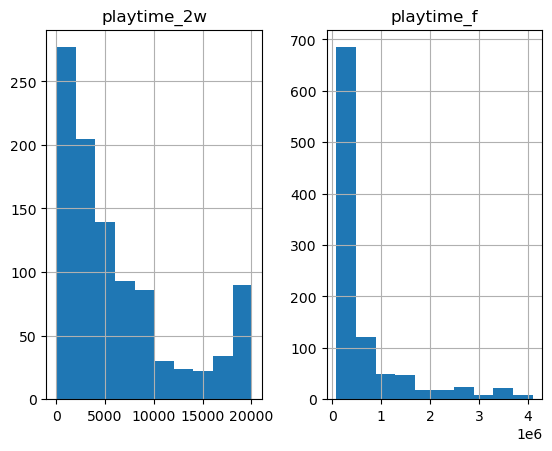

In [33]:
groupby_apps = recently_played_df.groupby('app_id').agg('mean') \
                                 .sort_values(by='playtime_f', ascending=False)
groupby_apps[:1000].hist()

In [34]:
# The playtime_2w column is very instructive in that there's a huge amount
# of records with about 20k minutes of playtime, which is also roughly
# the amount of minutes in 2 weeks.

# This suggests that some people may just leave games running, which may
# mean that playtime's usability as a feature may be extremely limited.

max_playtime = recently_played_df[recently_played_df['playtime_2w'] > 20000]
max_playtime.describe()


,app_id,playtime_2w,playtime_f
count,8.350000e+02,835.000000,8.350000e+02
mean,5.893876e+05,20064.898204,1.927071e+06
std,5.985079e+05,31.927683,1.399451e+06
min,1.000000e+01,20001.000000,2.245800e+04
25%,2.168600e+05,20040.000000,5.073370e+05
50%,4.035700e+05,20061.000000,2.020583e+06
75%,8.148750e+05,20089.000000,3.268261e+06
max,2.784840e+06,20159.000000,5.574135e+06


---------------